# Visualizing Read Depth Statistics

The depth and number of mapped reads are visualized in a series of plots. The data come from `mosdepth` and `samtools flagstat` commands.

In [1]:
import os
import csv
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
# Load phenotype data to convert sample id
pheno_df = (
    pd.read_csv('pdx_phenotype.csv', dtype='str')
    .drop_duplicates(subset=['final_id', 'sample_name'])
)

id_updater = dict(zip([x[0] for x in pheno_df.read_id.str.split('_')],
                      pheno_df.final_id))
id_updater

{'001-F0': '001-F0',
 '001-F5': '001-F5',
 '006-F0': '006-F0',
 '006-F5': '006-F5',
 '008-F0': '008-F0',
 '008-F5': '008-F5',
 '029-F0': '029-F0',
 '029-F5': '029-F5',
 '030-F0': '030-F0',
 '030-F5': '030-F5',
 '032-F0': '032-F0',
 '032-F5': '032-F5',
 '040-F0': '040-F0',
 '040-F5': '040-F5',
 '018-F0': '008-M1-F0',
 '018-F5': '008-M1-F5',
 '019-F0': '008-M2-F0',
 '019-F5': '008-M2-F5',
 '004-primary': '004-M',
 '004-F0': '004-M-F0',
 '004-F5': '004-M-F5',
 '005-primary': '005-M',
 '005-F0': '005-M-F0',
 '005-F5': '005-M-F5',
 'KS25': '008-ORTH-M',
 'KS26': '008-ORTH',
 'KS27': '048-F0',
 'KS28': '048-F5',
 'KS29': '048-M1-F0',
 'KS30': '048-M1-F5'}

## Mosdepth calculations of Coverage and Depth

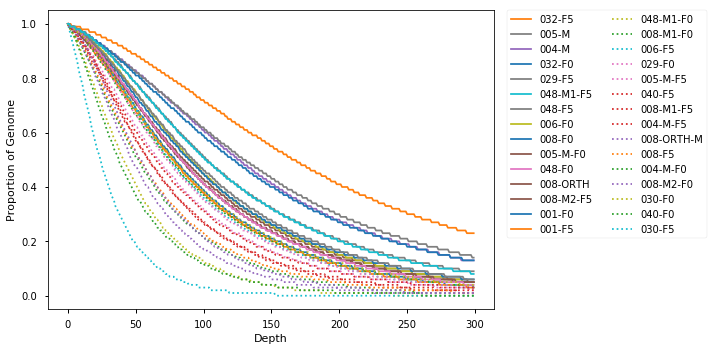

In [4]:
depth_dir = os.path.join('results', 'wes_stats')
depth_files = os.listdir(depth_dir)

plt.xlabel('Depth')
plt.ylabel('Proportion of Genome')
full_depth_list = []
all_samples = []
for depth_file in depth_files:
    # Load and process file
    full_depth_file = os.path.join(depth_dir, depth_file)

    # Update sample id from depth file with id_updated dictionary
    sample_id = id_updater[depth_file.split('.')[0]]
    
    depth_df = pd.read_table(full_depth_file, names=['chrom', 'depth', 'prop_cov'])
    depth_df = depth_df.assign(sample_id = sample_id)
    
    # Each line will be a different type if under a certain depth
    half_depth = depth_df.query('chrom == "total"').query('prop_cov >= 0.5').depth.max()

    # Ensure that the top half read depth estimations are solid lines
    if half_depth > 78 or sample_id == '001-F5':
        linestyle = 'solid'
    else:
        linestyle = 'dotted'

    # Store order and half depth of samples (for plot labeling later)
    all_samples.append([sample_id, half_depth])

    # Set a reasonable cutoff to view bulk of distribution
    depth_sub_df = depth_df[depth_df['depth'] < 300]
    
    # There are chromosome specific estimates, here, view total
    ax = plt.plot('depth',
                  'prop_cov',
                  linestyle=linestyle,
                  data=depth_sub_df.query('chrom == "total"'),
                  label=sample_id)
    
    # Save processed files to list for later extraction
    full_depth_list.append(depth_df)

# Get the default handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Sort the labels by their depth at 50% of the genome
sorted_labels = (
    pd.DataFrame(all_samples,
                 columns=['sample_id', 'half_depth'])
    .sort_values(by='half_depth', ascending=False)
    .sample_id
    .tolist()
)

# Sort the handles (matplotlib legend lines)
sorted_handles = [dict(zip(labels, handles))[x] for x in sorted_labels]

# Show legend in decreasing depth order
lgd = plt.legend(sorted_handles,
                 sorted_labels,
                 ncol=2,
                 bbox_to_anchor=(1.03, 1),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

# Save Figure
depth_fig_file = os.path.join('figures', 'mosdepth_estimation.pdf')
plt.savefig(depth_fig_file, bbox_extra_artists=(lgd,),
            bbox_inches='tight')

In [5]:
# Get full depth matrix
full_depth_df = pd.concat(full_depth_list)

# 50% of the exome is covered at what depth?
half_depth_df = full_depth_df[full_depth_df['prop_cov'] == 0.5]
half_depth_df = half_depth_df[half_depth_df['chrom'] == 'total']

In [6]:
half_depth_df.describe()

,depth,prop_cov
count,49.000000,49.0
mean,92.551020,0.5
std,33.592572,0.0
min,24.000000,0.5
25%,75.000000,0.5
50%,85.000000,0.5
75%,121.000000,0.5
max,168.000000,0.5


In [7]:
# 75% of the exome is covered at what depth?
threeq_depth_df = full_depth_df[full_depth_df['prop_cov'] == 0.75]
threeq_depth_df = threeq_depth_df[threeq_depth_df['chrom'] == 'total']

In [8]:
threeq_depth_df.describe()

,depth,prop_cov
count,44.000000,44.00
mean,49.000000,0.75
std,18.024531,0.00
min,19.000000,0.75
25%,38.000000,0.75
50%,45.000000,0.75
75%,63.250000,0.75
max,92.000000,0.75


## General flagstat read mapping distributions

In [9]:
read_stat_dir = os.path.join('results', 'read_counts')
read_stat_files = os.listdir(read_stat_dir)

In [10]:
read_stat_file = os.path.join(read_stat_dir, read_stat_files[0])

In [11]:
total_read_counts = []
mapped_read_counts = []

for read_stat_file in read_stat_files:
    read_stat_file = os.path.join(read_stat_dir, read_stat_file)

    with open(read_stat_file, 'r') as csvfile:
        readstat_reader = csv.reader(csvfile, delimiter=' ')
        line_idx = 0
        for row in readstat_reader:
            if line_idx == 0:
                total_read_counts.append(row[0])
            if line_idx == 2:
                mapped_read_counts.append(row[0])
            line_idx +=1

In [12]:
# Get flagstat dataframe
read_depth_df = pd.DataFrame([total_read_counts, mapped_read_counts],
                             index=['total', 'mapped'], dtype='float64').T

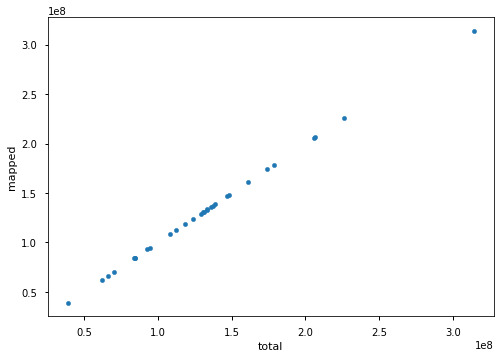

In [13]:
read_depth_df.plot(x='total', y='mapped', kind='scatter');

In [14]:
# Output distribution of total and mapped reads
read_depth_df.describe()

,total,mapped
count,3.000000e+01,3.000000e+01
mean,1.325271e+08,1.323409e+08
std,5.600751e+07,5.593092e+07
min,3.915586e+07,3.909243e+07
25%,9.347522e+07,9.334391e+07
50%,1.309524e+08,1.307663e+08
75%,1.478634e+08,1.476477e+08
max,3.142602e+08,3.138446e+08
